# Weak Kidney - Random Forest

In [1]:
import some_load_train_evaluate_functions as ml

In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Weak/Failing kidneys data

weak_kindey_df = ml.get_data_of_disease(driver, 'Weak/Failing kidneys')
weak_kindey_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Weak/Failing kidneys
0,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
1,93708,0,66,23.7,116.0,1.218750,0.192,0.127,NaN,0.7,...,109.00,22.0,13.2,58.32,2.870,247.0,32.0,30.1,0.655,0
2,93709,0,75,38.9,72.8,1.121212,0.009,0.017,28.561,0.6,...,129.00,31.0,15.4,NaN,NaN,NaN,21.0,46.5,NaN,0
3,93711,1,56,21.3,165.0,1.290323,0.173,0.079,31.115,0.4,...,40.60,19.0,14.7,31.68,4.086,139.0,16.0,34.8,0.542,0
4,93713,1,67,23.5,63.5,2.047619,0.028,0.028,18.344,0.6,...,238.00,26.0,14.2,NaN,NaN,123.0,27.0,28.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,102950,1,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5556,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,0
5557,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
5558,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0


### Training

In [26]:
random_forest = ml.RandomForestClassifier(random_state=42)

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

random_forest.fit(X_train, y_train)

# Accuracy scores

y_pred = random_forest.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, random_forest.predict(X_train)))

print('Testing Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.997976618705036
Testing Accuracy:  0.9991007194244604


## Feature Selection

### Correlation Analysis

In [5]:
random_forest_test = ml.RandomForestClassifier(random_state=42, n_jobs=-1)

In [7]:
pos_corr, neg_corr = ml.get_correlated_features(weak_kindey_df,'Weak/Failing kidneys',pos=0.0,neg=-0.0)

corr_features = list(pos_corr.keys()[1:]) + list(neg_corr.keys()[:])
corr_features.remove('Respondent_ID')
corr_features[:30]

['Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Retinol [umol/L]',
 'Osmolality [mmol/Kg]',
 'Age',
 'Ferritin [ng/mL]',
 'Uric Acid [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Chromium [nmol/L]',
 'Insulin [pmol/L]',
 'Potassium [mmol/L]',
 'Red cell distribution width [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Lactate Dehydrogenase [IU/L]',
 'Blood lead [umol/L]',
 'C-Reactive Protein [mg/L]',
 'Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Monocyte [%]',
 'Segmented neutrophils [%]',
 'BMI',
 'Platelet_Lymphocyte Ratio',
 'Eosinophils [%]',
 'Globulin [g/dL]',
 'Mean cell volume [fL]',
 'Transferrin receptor [nmol/L]',
 'Systemic Immune‐inflammation Index (SII)',
 'Basophils [%]',
 'Gamma Glutamyl Transferase [IU/L]']

In [8]:
ml.evaluate_feature_set(corr_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### SelectFromModel

In [9]:
sfm_features = ml.select_from_model_features(random_forest_test,X,y)
sfm_features

['Age',
 'BMI',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Blood manganese [nmol/L]',
 'Creatinine [mg/dL]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Uric Acid [mg/dL]',
 'Vitamin C [umol/L]',
 'Alanine Aminotransferase [U/L]',
 'Creatine Phosphokinase [IU/L]',
 'Ferritin [ng/mL]',
 'Lactate Dehydrogenase [IU/L]']

In [10]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### SelectKBest

In [11]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Retinol [umol/L]',
 'Age',
 'Osmolality [mmol/Kg]',
 'Ferritin [ng/mL]',
 'RBC count [million cells/uL]',
 'Uric Acid [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Hematocrit [%]',
 'Hemoglobin [g/dL]',
 'Albumin [g/dL]',
 'Lymphocyte [%]',
 'Potassium [mmol/L]',
 'Chromium [nmol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Red cell distribution width [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Lactate Dehydrogenase [IU/L]',
 'Blood lead [umol/L]',
 'C-Reactive Protein [mg/L]',
 'A/G Ratio',
 'Glycohemoglobin [%]',
 'Total Lycopene [umol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Trans-lycopene [umol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Insulin [pmol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Monocyte [%]']

In [12]:
ml.evaluate_feature_set(k_best_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Recursive Feature Elimination (RFE) 

In [13]:
rfe_features = ml.select_rfe_features(random_forest_test,X,y,n=30,step=0.5)
rfe_features[:30]

['Total Lycopene [umol/L]',
 'C-Reactive Protein [mg/L]',
 'Retinol [umol/L]',
 'Mean cell hemoglobin [pg]',
 'Glycohemoglobin [%]',
 'UIBC [umol/L]',
 'Gamma-tocopherol [umol/L]',
 'Ferritin [ng/mL]',
 'Eosinophils [%]',
 'Creatinine [mg/dL]',
 'Red cell distribution width [%]',
 'Alanine Aminotransferase [U/L]',
 'RBC count [million cells/uL]',
 'Vitamin C [umol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Blood manganese [nmol/L]',
 'Uric Acid [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Blood Urea Nitrogen [mg/dL]',
 'Transferrin receptor [nmol/L]',
 'Platelet count [1000 cells/uL]',
 'Lactate Dehydrogenase [IU/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Platelet_Lymphocyte Ratio',
 'Total Iron Binding Capacity [umol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'BMI',
 'Age',
 'Non_HDL Ratio']

In [14]:
ml.evaluate_feature_set(rfe_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Lasso Regularization

In [15]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Creatinine [mg/dL]',
 'Gender',
 'Age',
 'LDL_HDL Ratio',
 'Retinol [umol/L]',
 'Platelet_Lymphocyte Ratio',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Aspartate Aminotransferase [U/L]',
 'Ferritin [ng/mL]',
 'Phosphorus [mg/dL]',
 'Vitamin C [umol/L]',
 'Alanine Aminotransferase [U/L]',
 'Alkaline Phosphatase [IU/L]',
 'Lutein and zeaxanthin [umol/L]',
 'Total Bilirubin [mg/dL]',
 'Bicarbonate [mmol/L]',
 'Alpha-tocopherol [umol/L]',
 'A/G Ratio',
 'Blood lead [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Total Lycopene [umol/L]',
 'Blood selenium [umol/L]',
 'Uric Acid [mg/dL]',
 'Transferrin receptor [nmol/L]',
 'Platelet_WBC Ratio',
 'Iron frozen [umol/L]',
 'White blood cell count [1000 cells/uL]',
 'Iron [ug/dL]',
 'Nucleated RBCs']

In [16]:
ml.evaluate_feature_set(l1_selected_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Relief F

In [17]:
relieff_features = ml.relief_feature_select(30,X,y)

In [18]:
relieff_features[:30]

['Nucleated RBCs',
 'Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Age',
 'Hemoglobin [g/dL]',
 'Hematocrit [%]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'RBC count [million cells/uL]',
 'Uric Acid [mg/dL]',
 'Non_HDL Ratio',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Neutrophil_Lymphocyte Ratio',
 'Lymphocyte [%]',
 'Albumin [g/dL]',
 'Gender',
 'Transferrin Saturation [%]',
 'Chloride [mmol/L]',
 'UIBC [umol/L]',
 'Glycohemoglobin [%]',
 'Red cell distribution width [%]',
 'Globulin [g/dL]',
 'Total Protein [g/dL]',
 'A/G Ratio',
 'Segmented neutrophils [%]',
 'Total Lycopene [umol/L]',
 'Alpha-tocopherol [umol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Iron frozen [umol/L]']

In [19]:
ml.evaluate_feature_set(relieff_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.997

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Random Forest Feature Importances

In [20]:
random_forest_features = ml.get_rand_forest_features(random_forest, X_train)
random_forest_features[:30]

['Creatinine [mg/dL]',
 'Blood Urea Nitrogen [mg/dL]',
 'Age',
 'BMI',
 'Ferritin [ng/mL]',
 'Retinol [umol/L]',
 'Osmolality [mmol/Kg]',
 'Uric Acid [mg/dL]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Vitamin C [umol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Alanine Aminotransferase [U/L]',
 'Creatine Phosphokinase [IU/L]',
 'Transferrin receptor [nmol/L]',
 'Iron [ug/dL]',
 'RBC count [million cells/uL]',
 'Alkaline Phosphatase [IU/L]',
 'Iron frozen [umol/L]',
 'Blood cadmium [nmol/L]',
 'Lutein and zeaxanthin [umol/L]',
 'Platelet_Lymphocyte Ratio',
 'Beta-cryptoxanthin [umol/L]',
 'Blood lead [umol/L]',
 'Basophils [%]',
 'Mean cell volume [fL]',
 'Blood manganese [nmol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Total Cholestrol_HDL Ratio']

In [21]:
ml.evaluate_feature_set(random_forest_features, random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Optimal no. of features

In [22]:
final_features = list(random_forest_features) 

Finding optimal no. of features..: 100%|████████| 85/85 [05:08<00:00,  3.62s/it]


Maximum f1 = 0.3406 for 6 features


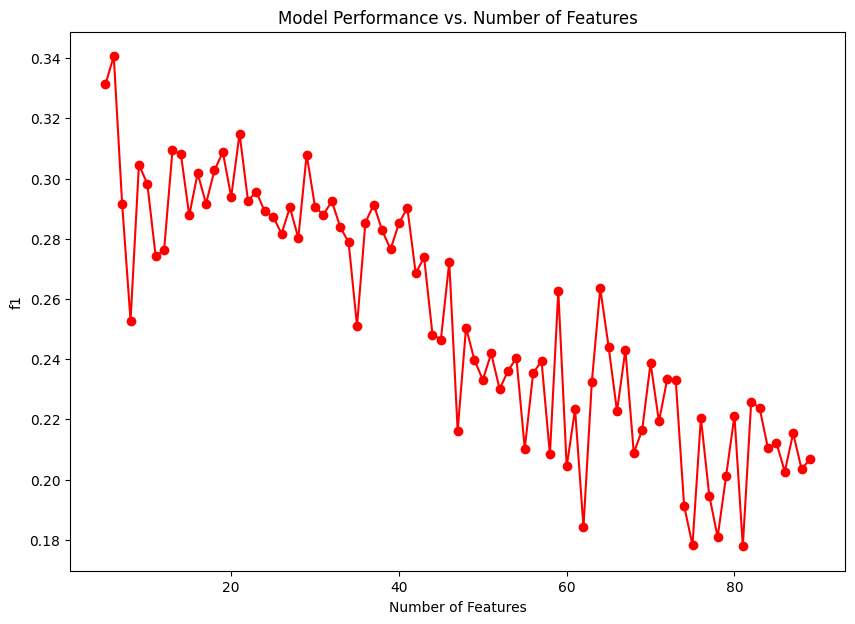

In [24]:
# Optimal no. of features

ml.plot_num_feature_performance(random_forest_test,  X, y, final_features, scoring='f1')

Finding optimal no. of features..: 100%|████████| 85/85 [05:10<00:00,  3.65s/it]


Maximum recall = 0.2336 for 6 features


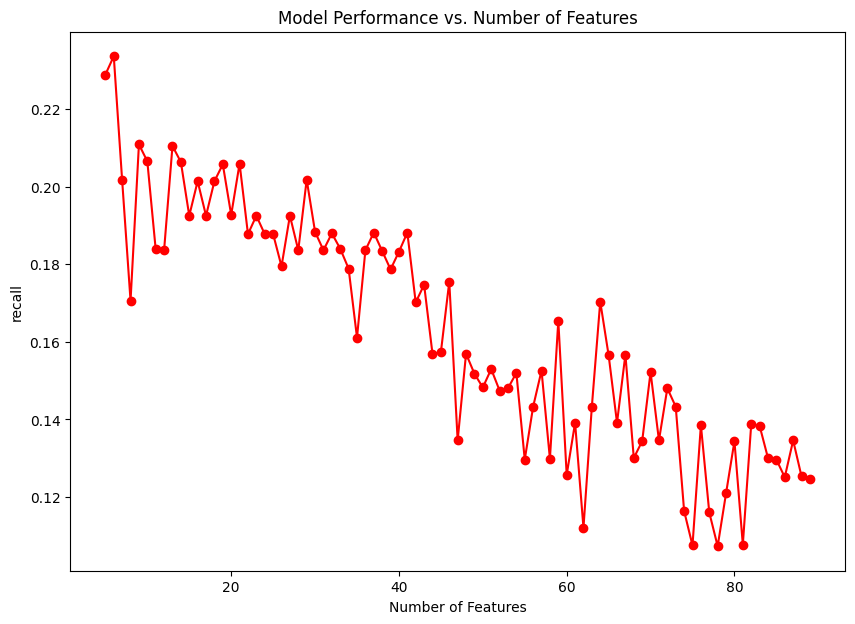

In [25]:
# Optimal no. of features

ml.plot_num_feature_performance(random_forest_test,  X, y, final_features, scoring='recall')

In [28]:
num_features = 6

selected = final_features[:num_features]
selected.append('Weak/Failing kidneys')

weak_kindey_df = weak_kindey_df[selected]

In [29]:
# Save feature set
    
with open('../Models/Weak kidneys/Feature Sets/Random Forest Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### No Imputation

In [30]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                        impute = False, scale=True,
                                                        imputer=None,
                                                        random_state=42)

In [31]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.973

Test Accuracy: 0.977

Precision: 1.000

Recall: 0.446

F1-Score: 0.617


### Zero Imputation

In [32]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [33]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Mode Imputation

In [34]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [35]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### k-NN Imputation

In [36]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [37]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Multiple Imputation by Chained Equations (MICE)

In [38]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [39]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Mean Imputation

In [40]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [41]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.967

F1-Score: 0.983


### Median Imputation

In [42]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df, label = 'Weak/Failing kidneys',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [43]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.998

Test Accuracy: 0.999

Precision: 1.000

Recall: 0.978

F1-Score: 0.989


### Dropping Null Values

In [44]:
# Drop null values
weak_kindey_df_na = weak_kindey_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = weak_kindey_df_na, label = 'Weak/Failing kidneys',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [45]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


## Oversampling and Undersampling

### Random Oversampling

In [46]:
X_ros, y_ros = ml.random_over_sample(X_train, y_train)

random_forest.fit(X_ros, y_ros)

ml.evaluate_model_metrics(random_forest,X_ros, y_ros,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### SMOTE (Synthetic Minority Over-sampling Technique)

In [47]:
X_smote, y_smote = ml.smote_over_sample(X_train, y_train)

random_forest.fit(X_smote, y_smote)

ml.evaluate_model_metrics(random_forest,X_smote, y_smote,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Random Undersampling

In [48]:
X_rus, y_rus = ml.random_under_sample(X_train, y_train)

random_forest.fit(X_rus, y_rus)

ml.evaluate_model_metrics(random_forest,X_rus, y_rus,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 0.806

Precision: 0.160

Recall: 1.000

F1-Score: 0.276


### Tomek Links

In [49]:
X_tomek, y_tomek = ml.tomek_links(X_train, y_train)

random_forest.fit(X_tomek, y_tomek)

ml.evaluate_model_metrics(random_forest,X_tomek, y_tomek,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 0.999

Precision: 0.973

Recall: 1.000

F1-Score: 0.986


### SMOTE + Tomek Links

In [50]:
X_smote_tomek, y_smote_tomek = ml.smote_tomek(X_train, y_train)

random_forest.fit(X_smote_tomek, y_smote_tomek)

ml.evaluate_model_metrics(random_forest,X_smote_tomek, y_smote_tomek,X_val, y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


In [51]:
# X_train, y_train = X_smote_tomek, y_smote_tomek

## Hyperparameter Optimization 

### Grid Search

In [52]:
param_grid = {
    
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_jobs': [-1],
    'random_state': [42]

}

In [53]:
grid_best_params, random_forest_grid = ml.grid_search_optimize(random_forest, param_grid, X_train, 
                                                                y_train, cv=10,scoring='accuracy')

In [54]:
grid_best_params

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': None,
 'n_jobs': -1,
 'random_state': 42}

In [55]:
ml.evaluate_model_metrics(random_forest_grid,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Random Search

In [56]:
rand_best_params, random_forest_rand = ml.random_search_optimize(random_forest,param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy')

In [57]:
rand_best_params

{'random_state': 42,
 'n_jobs': -1,
 'max_features': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [58]:
ml.evaluate_model_metrics(random_forest_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Optuna

In [59]:
def objective(trial):

    params = {
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1])
    }
     
    model = ml.RandomForestClassifier(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = ml.accuracy_score(y_test, y_pred)

    return accuracy

In [60]:
best_trial , random_forest_opt = ml.optuna_optimize(objective, ml.RandomForestClassifier, n_trials=150)

In [61]:
best_trial

{'bootstrap': False, 'criterion': 'gini', 'n_jobs': -1}

In [62]:
random_forest_opt.fit(X_train,y_train)

ml.evaluate_model_metrics(random_forest_opt,X_train,y_train,X_val,y_val)


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


## Evaluation on Test Set


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000

Confusion Matrix:

[[1843    0]
 [   0   77]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1843
     Class 1       1.00      1.00      1.00        77

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920


ROC-AUC Curve:


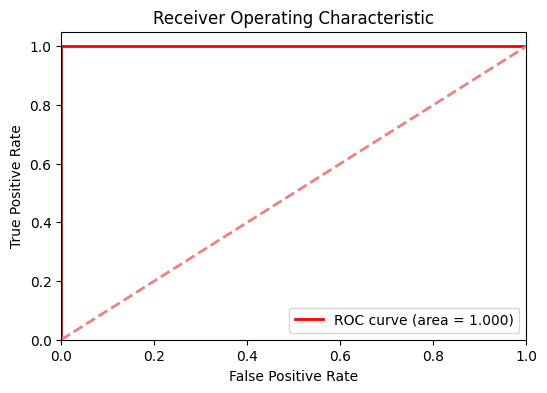

In [63]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(random_forest_grid, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [64]:
ml.k_cross_validate(random_forest,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.96881497 0.96666667 0.96041667 0.96666667 0.96041667 0.95416667
 0.9625     0.96666667 0.97083333 0.96458333]

Mean accuracy score:  0.9641731635481635

Standard deviation:  0.004646257893192659


In [65]:
ml.k_cross_validate(random_forest_grid,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.97089397 0.96875    0.9625     0.96666667 0.96041667 0.95833333
 0.96041667 0.96875    0.97083333 0.96041667]

Mean accuracy score:  0.9647977304227305

Standard deviation:  0.0046149279129084975


In [66]:
ml.k_cross_validate(random_forest_rand,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.97089397 0.96875    0.9625     0.96666667 0.96041667 0.95833333
 0.96041667 0.96875    0.97083333 0.96041667]

Mean accuracy score:  0.9647977304227305

Standard deviation:  0.0046149279129084975


In [67]:
ml.k_cross_validate(random_forest_opt,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.97089397 0.96458333 0.96041667 0.96666667 0.96041667 0.95833333
 0.9625     0.96666667 0.97291667 0.9625    ]

Mean accuracy score:  0.9645893970893973

Standard deviation:  0.004476762853984227


### Stratified K-fold

In [68]:
ml.stratified_k_cross_validate(random_forest,X,y,n_splits=10)


Average Accuracy: 0.9639643970893971

Average Precision: 0.6182142857142857

Average Recall: 0.23479532163742686

Average F1-Score: 0.3320984269769877


In [69]:
ml.stratified_k_cross_validate(random_forest_grid,X,y,n_splits=10)


Average Accuracy: 0.9635481635481635

Average Precision: 0.6087121212121213

Average Recall: 0.22953216374269

Average F1-Score: 0.32613986657464916


In [70]:
ml.stratified_k_cross_validate(random_forest_rand,X,y,n_splits=10)


Average Accuracy: 0.9635481635481635

Average Precision: 0.6087121212121213

Average Recall: 0.22953216374269

Average F1-Score: 0.32613986657464916


In [71]:
ml.stratified_k_cross_validate(random_forest_opt,X,y,n_splits=10)


Average Accuracy: 0.9633398302148303

Average Precision: 0.5926329226329226

Average Recall: 0.25087719298245614

Average F1-Score: 0.34471374965752777


### Save Model

In [72]:
final_random_forest_estimator = random_forest_opt

In [73]:
# Saving the model

ml.save_model(final_random_forest_estimator, "../Models/Weak kidneys/Random_Forest_Classifier.pkl")

Saved Model


## Prediction

In [75]:
# Predicting on perturbed values

sc = ml.np.random.rand()

ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[0], y_test.iloc[0], sc)

Instance:
 [ 0.63848054 -0.81790778 -1.1466565  -0.48994806 -0.81833195  0.60730492]

Expected Class:  0

 Modified Instance:
 [ 0.63848054 -0.8568463  -1.15919928 -0.5839045  -0.83843433  0.58573703]

Predicted Class:  [0]


In [78]:
ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[18], y_test.iloc[18], sc)

Instance:
 [ 1.62612029  3.09013769  0.73041767  0.31902452 -0.20049924  1.12684908]

Expected Class:  1

 Modified Instance:
 [ 1.62612029  3.02916508  0.58403746  0.39218316 -0.14131574  1.03893202]

Predicted Class:  [0]


In [85]:
ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[126], y_test.iloc[126], sc)

Instance:
 [0.94081924 1.9502911  1.01482285 0.49430191 7.28093483 3.11089227]

Expected Class:  1

 Modified Instance:
 [0.94081924 2.05972709 1.16765373 0.50618877 7.17506551 3.22497487]

Predicted Class:  [1]
